**Day ahead Energy trading for Great Britain market**

Using this [UK Energy Trading Dataset](https://www.kaggle.com/datasets/kapilverma/uk-energy-trading) through a systematic approach, we will seek to develop a simple trading algorithm to maximize profits from non-physical financial trades between two auctions of the day-ahead market in Great Britain's electricity market.

Our approach will involve:
* data preprocessing
* developing a price forecasting model
* determining the optimal trading strategy
* implementing the trading algorithm in Python
* finally testing and optimizing the algorithm. 

We will go through these steps one by one.

# 1. Gather and preprocess the data
Let‘s first preprocess all of the input data by cleaning and formatting it in a way that can be used by the algorithm. Starting with Auction Data which has actual prices and traded volumes data of both auctions as well as the price forecast for the first auction.

First let's see the files we have in the dataset.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/uk-energy-trading/auction_data.csv
/kaggle/input/uk-energy-trading/forecast_inputs.csv
/kaggle/input/uk-energy-trading/description_input_variables.txt
/kaggle/input/uk-energy-trading/system_prices.csv


In [2]:
auc_df = pd.read_csv('/kaggle/input/uk-energy-trading/auction_data.csv',delimiter=';')
auc_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
0,NaN,GBP/MWh,GBP/MWh,MW,MW,GBP/MWh
1,[01/01/2021 00:00],68,65.73,2923.7,5102.4,54.19
2,[01/01/2021 01:00],62.7,64.96,2825,4771.5,53.42
3,[01/01/2021 02:00],56,60.47,2611.4,4176.2,50.13
4,[01/01/2021 03:00],50.1,52.5,2669.3,3755.9,50.28


We can skip the top row which gives us the units for each feature.

In [3]:
auc_df = auc_df[1:]
auc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14879 entries, 1 to 14879
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date (WET)                    14879 non-null  object
 1   price_first_auction           14879 non-null  object
 2   price_second_auction          14879 non-null  object
 3   traded_volume_first_auction   14879 non-null  object
 4   traded_volume_second_auction  14877 non-null  object
 5   price_forecast_first_auction  14831 non-null  object
dtypes: object(6)
memory usage: 697.6+ KB


All columns are having Data types as object they need to be changed to numeric Data types.  We will start with parsing dates and then convert the rest to their numeric types.

In [4]:
auc_df['Date (WET)'] = auc_df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
auc_df[auc_df.columns[1:]] = auc_df[auc_df.columns[1:]].apply(lambda x: pd.to_numeric(x))
auc_df.head()

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
1,2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19
2,2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42
3,2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13
4,2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28
5,2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19


All columns are now of numeric type. Now, we will be dropping entirely empty rows, if present.

In [5]:
auc_df=auc_df.dropna(how='all')

auc_df.duplicated().sum()

0

There are no duplicates in the dataset.
#### Missing values treatment:

In [6]:
def get_null_cols(df):
    null_dict = {}
    for i in df.columns:
        if df[i].isnull().sum()>0:
            null_dict[i] = df[i].isnull().sum()
    return null_dict

get_null_cols(auc_df)

{'traded_volume_second_auction': 2, 'price_forecast_first_auction': 48}

Missing values in price_forecast_first_auction column are significant and as we see below they are continuous too. We need to find a proper method to impute these values.

In [7]:
auc_df[auc_df.isnull().any(axis=1)].head(10)

,Date (WET),price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction
1537,2021-03-06 00:00:00,53.3,52.93,3190.4,7455.2,NaN
1538,2021-03-06 01:00:00,52.4,49.08,3093.5,7170.2,NaN
1539,2021-03-06 02:00:00,48.5,48.55,3152.6,6924.2,NaN
1540,2021-03-06 03:00:00,45.0,46.90,3164.6,6688.0,NaN
1541,2021-03-06 04:00:00,45.0,43.55,3460.0,6738.8,NaN
1542,2021-03-06 05:00:00,46.0,43.60,3394.4,6863.3,NaN
1543,2021-03-06 06:00:00,50.0,51.36,3551.3,7109.6,NaN
1544,2021-03-06 07:00:00,52.7,50.00,3521.8,6976.8,NaN
1545,2021-03-06 08:00:00,57.8,55.00,3866.3,7319.9,NaN
1546,2021-03-06 09:00:00,61.0,65.13,3906.3,7932.7,NaN


#### Searching for optimal method to deal with missing values:
We will be creating a subset dataframe `'ref_df'` from the actual data to see which method will give us the most closest values to the actual missing values. For this purpose, I have removed 24 actual value from the target column `tar` so that we can compare the results. <br> We don‘t want to use the simple mean and median imputation as they will give us only static values.

In [8]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = auc_df['price_forecast_first_auction'][:1500]
ref_df['tar'] = auc_df['price_forecast_first_auction'][:1476]
ref_df

,ref,tar
1,54.19,54.19
2,53.42,53.42
3,50.13,50.13
4,50.28,50.28
5,47.19,47.19
...,...,...
1496,64.43,NaN
1497,71.53,NaN
1498,72.68,NaN
1499,71.35,NaN


We are trying out various methods such as *rolling mean, rolling median and spline interpolation,* which fits low-degree polynomials to small subsets of the values. We will use RMSE values to determine which one among these methods is best to use to fill missing values.

In [9]:
def search_filling_method(ref_df):
    ref_df = ref_df.assign(Rollavg=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).mean()))
    ref_df = ref_df.assign(RollMedian=ref_df.tar.fillna(ref_df.tar.rolling(25,min_periods=1,).median()))
    ref_df = ref_df.assign(InterpolateSpline3=ref_df.tar.interpolate(method='spline', order=3))
    ref_df = ref_df.assign(InterpolateSpline4=ref_df.tar.interpolate(method='spline', order=4))
    ref_df = ref_df.assign(InterpolateSpline5=ref_df.tar.interpolate(method='spline', order=5))

    results = [(method, np.sqrt(metrics.mean_squared_error(ref_df.ref, ref_df[method]))) 
               for method in list(ref_df)[2:]]
    results_df = pd.DataFrame(np.array(results), columns=['Method', 'RMSE'])
    results_df.sort_values(by='RMSE', ascending=False)
    return results_df
results_df = search_filling_method(ref_df)
results_df

,Method,RMSE
0,Rollavg,6.637092702431262
1,RollMedian,6.986361141538562
2,InterpolateSpline3,16491.599722406107
3,InterpolateSpline4,198115.55081577832
4,InterpolateSpline5,11125436.832408043


Here we see Simple moving average method or simply, rolling average is best for our purpose. We will plot to visualize and then finally fill the values.

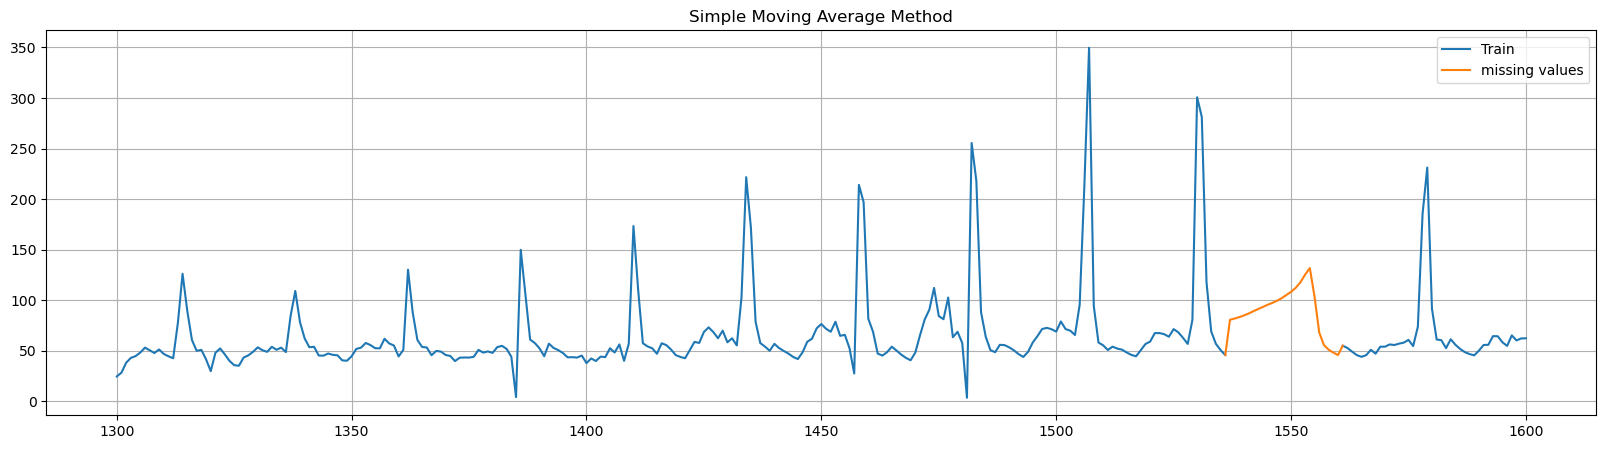

In [10]:
#Simple moving average method 
y_pred =auc_df.copy()
y_pred['price_forecast_first_auction'] = auc_df.price_forecast_first_auction.fillna(
    auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auc_df['price_forecast_first_auction'].loc[1300:1600], label='Train')
plt.plot(y_pred['price_forecast_first_auction'].loc[1536:1561], label='missing values')
plt.legend(loc='best')
plt.title('Simple Moving Average Method');

In [11]:
auc_df.price_forecast_first_auction = auc_df.price_forecast_first_auction.fillna(
                                      auc_df.price_forecast_first_auction.rolling(25,min_periods=1,).mean())
auc_df = auc_df.bfill()
get_null_cols(auc_df)

{}

The empty dict above suggests that there are no missing values in `auc_df`. Now, let's read and process other datasets too. Starting with **system_prices.csv** as `sys_df`

In [12]:
def read_preprocess(filepath):
    df = pd.read_csv(filepath,delimiter=';')
    df = df[1:]
    df['Date (WET)'] = df['Date (WET)'].apply(lambda x: (datetime.strptime(x, '[%d/%m/%Y %H:%M]')))
    df[df.columns[1:]] = df[df.columns[1:]].apply(lambda x: pd.to_numeric(x,errors='coerce'))
    df = df.dropna(how='all')
    print(f'Duplicate rows:{df.duplicated().sum()}')
    print(f'Null Values:{get_null_cols(df)}')
    return df

sys_df = read_preprocess('/kaggle/input/uk-energy-trading/system_prices.csv')
print('\n')
sys_df.head()

Duplicate rows:0
Null Values:{'forecast_system_price_low': 48, 'forecast_system_price_high': 48, 'system_price': 44}




,Date (WET),forecast_system_price_low,forecast_system_price_high,system_price
1,2021-01-01 00:00:00,48.33,44.89,73.15
2,2021-01-01 01:00:00,54.35,53.26,71.95
3,2021-01-01 02:00:00,32.66,65.86,54.56
4,2021-01-01 03:00:00,41.55,63.43,70.73
5,2021-01-01 04:00:00,26.62,66.91,54.98


There are significant missing values in 3 columns and again as we see below they are continuous in nature. We will be using our previuos approach to find a proper method to impute these values. We will use our function `search_filling_method` to do it efficiently.

In [13]:
sys_df[sys_df.isnull().any(axis=1)].loc[1500:1550]

,Date (WET),forecast_system_price_low,forecast_system_price_high,system_price
1537,2021-03-06 00:00:00,NaN,NaN,42.40
1538,2021-03-06 01:00:00,NaN,NaN,42.60
1539,2021-03-06 02:00:00,NaN,NaN,56.65
1540,2021-03-06 03:00:00,NaN,NaN,55.95
1541,2021-03-06 04:00:00,NaN,NaN,55.93
1542,2021-03-06 05:00:00,NaN,NaN,55.95
1543,2021-03-06 06:00:00,NaN,NaN,55.90
1544,2021-03-06 07:00:00,NaN,NaN,54.65
1545,2021-03-06 08:00:00,NaN,NaN,62.73
1546,2021-03-06 09:00:00,NaN,NaN,86.00


In [14]:
ref_df = pd.DataFrame(columns=['ref','tar'])
ref_df['ref'] = sys_df['system_price'][:600]
ref_df['tar'] = sys_df['system_price'][:576]
search_filling_method(ref_df)

,Method,RMSE
0,Rollavg,5.300130320679532
1,RollMedian,5.164011352621139
2,InterpolateSpline3,44738.99872450196
3,InterpolateSpline4,684457.1159529577
4,InterpolateSpline5,37620291.62669144


**Filling system_price column** <br>
Here, we see simple moving median method or simply "rolling median" is best method for our purpose. We will first plot to visualize the potential values and then we will actually fill those values.

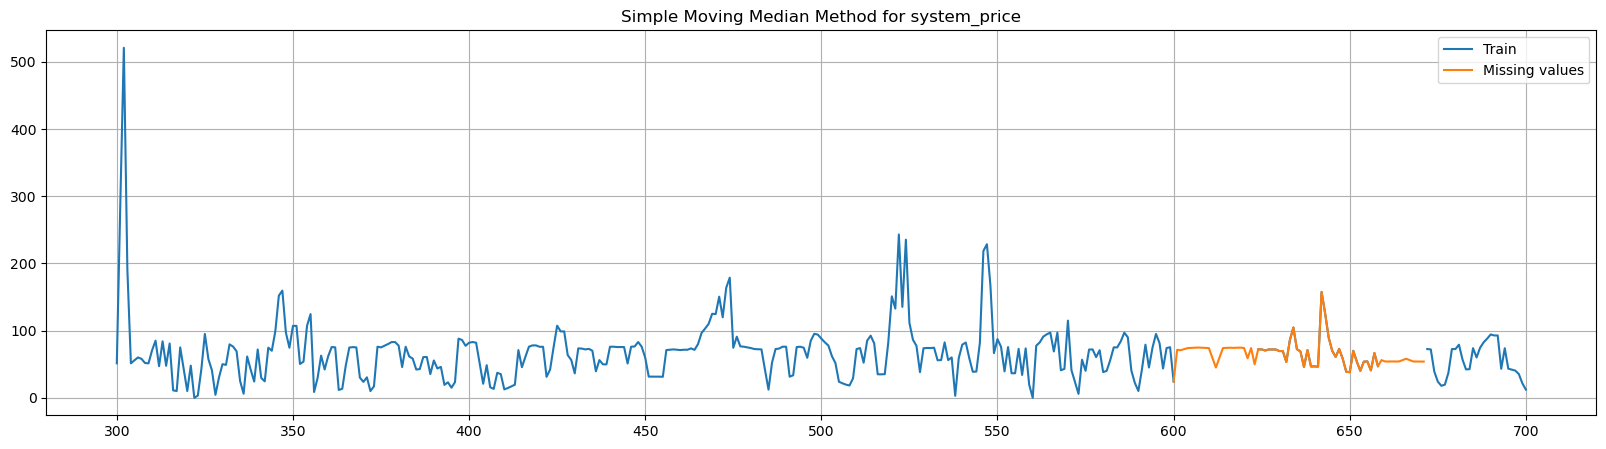

In [15]:
#Simple moving median method 
y_pred =sys_df.copy()
y_pred['system_price'] = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

plt.figure(figsize=(20,5))
plt.grid()
plt.plot(sys_df['system_price'].loc[300:700], label='Train')
plt.plot(y_pred['system_price'].loc[600:671], label='Missing values')
plt.legend(loc='best')
plt.title('Simple Moving Median Method for system_price');

#filling missing values
sys_df.system_price = sys_df.system_price.fillna(
    sys_df.system_price.rolling(25,min_periods=1,).median())

We have 2 more columns to fill so it will be better to write a function to deal with multiple columns at once in the same way.

In [16]:
def miss_val_fill_method(df,u_index,l_index):
    miss_val_fill_methods = {}
    miss_val_cols = [i for i in get_null_cols(df) if get_null_cols(df)[i]>5]
    for col_name in miss_val_cols:
        ref_df = pd.DataFrame(columns=['ref','tar'])
        ref_df['ref'] = df[col_name][:u_index]
        ref_df['tar'] = df[col_name][:l_index]
        results_df = search_filling_method(ref_df)
        miss_val_fill_methods[col_name] = results_df.Method[0]
    return miss_val_fill_methods

result_dict= miss_val_fill_method(sys_df,1500,1476)
print(result_dict)
print('\n')

for col in result_dict.keys():
    print(f'missing values filled in {col}')
    sys_df[col] = sys_df[col].fillna(sys_df[col].rolling(25,min_periods=1,).mean())
sys_df = sys_df.bfill()
get_null_cols(sys_df)

{'forecast_system_price_low': 'Rollavg', 'forecast_system_price_high': 'Rollavg'}


missing values filled in forecast_system_price_low
missing values filled in forecast_system_price_high


{}

We have found our suitable methods (Rollavg) and above we have already used them to fill the respective missing values too.

# 2. Develop a pricing model for the second auction: 
After pre-processing the data, now, we will use the input variables given in **forecast_inputs.csv** to develop a pricing model for the second auction. We can use various techniques such as linear regression, time series analysis, or machine learning to develop the pricing model. The pricing model should be able to forecast the prices of the second auction based on the input variables. We have the data description of different input variables of forecast_input.csv in `description_input_variables.txt` as given below:

**Data Dictionary**

* `Demand + System Margin` - The availability of the system, using the daily forecast availability data (UOU data) except in the case of wind farms where a wind forecast is used from GFS weather data.

* `Demand` - An adjustment of the demand forecast to add back on embedded wind and solar to get a truer demand shape. For values beyond the end of the half hourly demand data from National Grid, the data is shaped from the published peak demand values using typical demand curves.

* `Within Day Availability` - An adjusted availability figure for the system that is reduced based upon rules around likely plant issues and potential non-delivery of potential availability.

* `Margin` - The difference between Availability and Demand forecasted.

* `Within Day Margin` - The difference between the Within Day Availability and Demand forecasted.

* `Long-Term Wind` - A wind forecast based upon GFS weather data.

* `Long-Term Solar` - National Grid solar forecast.

* `Long-Term Wind Over Demand` - The Long-Term Wind values divided by Demand values.

* `Long-Term Wind Over Margin` - The Long-Term Wind values divided by Margin values.

* `Long-Term Solar Over Demand` - The Long-Term Solar values divided by Demand values.

* `Long-Term Solar Over Margin` - The Long-Term Solar values divided by Margin values.

* `Margin Over Demand` - The Margin values divided by Demand values.

* `SNSP Forecast` - forecasts system non-synchronous penetration, which is a the percentage of how much generation or imports that will be on the system that are not synchronised with frequency

* `Stack Price` - The breakeven cost of generation as reported by a stack model. This stack model uses as inputs Spectron daily carbon, coal and gas prices (based upon closing prices) and uses UOU 2-14 day availability forecast data by unit. Where margin levels are tight an uplift is applied to reflect the increase reluctance to generate given the risk of high imbalance prices.

* `Within Day Stack Price` - As with the Stack Price values, but using reduced levels of availability via the same reductions carried out for the Within Day Availability data set.

* `Previous Day-Ahead Price` - Gets the last day ahead price value (last published before the auction).

* `Previous Continuous Half-Hour Volume-Weighted Average Price (VWAP)` - Gets the volume weighted average price of all trades on half-hourly contracts in the continuous intraday market from 7 days before, ie on a Monday it will be for the previous Monday.

* `Inertia Forecast` - a forecast for pre-balancing Inertia based upon the fundamentals based generation forecast data.

Let's read and process the forecasting dataset.

In [17]:
for_df = read_preprocess('/kaggle/input/uk-energy-trading/forecast_inputs.csv')
print('\n')
for_df.head()

Duplicate rows:0
Null Values:{'demand_plus_system_margin': 1, 'margin': 1, 'long_term_solar': 49, 'long_term_solar_over_demand': 48, 'long_term_solar_over_margin': 48, 'margin_over_demand': 1, 'snsp_forecast': 48, 'stack_price': 1, 'previous_day_ahead_price': 84, 'previous_continuous_half_hour_vwap': 34}




,Date (WET),demand_plus_system_margin,demand,within_day_availability,margin,within_day_margin,long_term_wind,long_term_solar,long_term_wind_over_demand,long_term_wind_over_margin,long_term_solar_over_demand,long_term_solar_over_margin,margin_over_demand,snsp_forecast,stack_price,within_day_potential_stack_price,previous_day_ahead_price,previous_continuous_half_hour_vwap,inertia_forecast
1,2021-01-01 00:00:00,56513.64,30182.0,40389.06,-26331.64,-15268.70,-3674.64,0.0,-12,-14,0.0,0.0,-87.0,29.95,67.79,68.88,65.02,59.69,214.67
2,2021-01-01 01:00:00,56506.94,29269.0,40389.06,-27237.94,-16191.00,-3667.94,0.0,-13,-14,0.0,0.0,-93.0,31.05,67.79,68.45,62.00,51.86,205.47
3,2021-01-01 02:00:00,56502.20,27245.0,40389.06,-29257.20,-18226.26,-3663.20,0.0,-14,-13,0.0,0.0,-108.0,32.80,67.73,67.79,54.16,46.29,191.12
4,2021-01-01 03:00:00,56487.24,25545.5,40389.06,-30941.74,-19935.30,-3648.24,0.0,-15,-12,0.0,0.0,-121.0,34.95,67.61,67.73,51.94,54.22,176.23
5,2021-01-01 04:00:00,56373.63,24180.0,40389.06,-32193.63,-21212.69,-3534.63,0.0,-15,-11,0.0,0.0,-134.0,36.70,66.48,67.67,49.17,57.26,163.59


There are missing values in 10 columns we will use the same approach as before to fill the missing values, it will make sense only for columns which are having more than 1 missing values (as shown below).

In [18]:
result_dict = miss_val_fill_method(for_df,1500,1476)
result_dict

{'long_term_solar': 'Rollavg',
 'long_term_solar_over_demand': 'Rollavg',
 'long_term_solar_over_margin': 'Rollavg',
 'snsp_forecast': 'Rollavg',
 'previous_day_ahead_price': 'Rollavg',
 'previous_continuous_half_hour_vwap': 'Rollavg'}

As the result above sugeests we should use rolling average method to fill missing values in the all of the above 6 columns.

In [19]:
for col in result_dict.keys():
    print(f'missing values filled in {col}')
    for_df[col] = for_df[col].fillna(for_df[col].rolling(25,min_periods=1,).mean())
for_df = for_df.bfill()
get_null_cols(for_df)

missing values filled in long_term_solar
missing values filled in long_term_solar_over_demand
missing values filled in long_term_solar_over_margin
missing values filled in snsp_forecast
missing values filled in previous_day_ahead_price
missing values filled in previous_continuous_half_hour_vwap


{}

For convenience, we should be adding relevant features from auction data into the input data for forecasting. We can join them as we have ensured that all columns are now of numeric type and there are no missing values.

In [20]:
for_df = for_df.join(auc_df[['Date (WET)','price_second_auction','traded_volume_second_auction']].set_index(
                    'Date (WET)'),on='Date (WET)')
for_df = for_df.bfill()
for_df.head()

,Date (WET),demand_plus_system_margin,demand,within_day_availability,margin,within_day_margin,long_term_wind,long_term_solar,long_term_wind_over_demand,long_term_wind_over_margin,...,long_term_solar_over_margin,margin_over_demand,snsp_forecast,stack_price,within_day_potential_stack_price,previous_day_ahead_price,previous_continuous_half_hour_vwap,inertia_forecast,price_second_auction,traded_volume_second_auction
1,2021-01-01 00:00:00,56513.64,30182.0,40389.06,-26331.64,-15268.70,-3674.64,0.0,-12,-14,...,0.0,-87.0,29.95,67.79,68.88,65.02,59.69,214.67,65.73,5102.4
2,2021-01-01 01:00:00,56506.94,29269.0,40389.06,-27237.94,-16191.00,-3667.94,0.0,-13,-14,...,0.0,-93.0,31.05,67.79,68.45,62.00,51.86,205.47,64.96,4771.5
3,2021-01-01 02:00:00,56502.20,27245.0,40389.06,-29257.20,-18226.26,-3663.20,0.0,-14,-13,...,0.0,-108.0,32.80,67.73,67.79,54.16,46.29,191.12,60.47,4176.2
4,2021-01-01 03:00:00,56487.24,25545.5,40389.06,-30941.74,-19935.30,-3648.24,0.0,-15,-12,...,0.0,-121.0,34.95,67.61,67.73,51.94,54.22,176.23,52.50,3755.9
5,2021-01-01 04:00:00,56373.63,24180.0,40389.06,-32193.63,-21212.69,-3534.63,0.0,-15,-11,...,0.0,-134.0,36.70,66.48,67.67,49.17,57.26,163.59,48.98,4047.5


#### Skewness & Outliers

In [21]:
for_df[for_df.describe().columns[1:]].skew(axis=0, skipna=True).sort_values(ascending=False)

previous_continuous_half_hour_vwap    6.046551
price_second_auction                  3.742994
previous_day_ahead_price              3.217815
within_day_potential_stack_price      1.696613
stack_price                           1.323437
snsp_forecast                         0.380093
inertia_forecast                      0.262795
demand                                0.176571
traded_volume_second_auction          0.148789
within_day_availability               0.081035
long_term_wind_over_margin           -0.149518
within_day_margin                    -0.304949
margin                               -0.364723
long_term_wind                       -0.434660
long_term_wind_over_demand           -0.716600
margin_over_demand                   -0.736933
long_term_solar                      -1.362301
long_term_solar_over_demand          -1.401543
long_term_solar_over_margin          -2.216577
dtype: float64

When we observe closely we see that mostly, columns related to prices are highly skewed to the right and the other long term columns with `long_term` prefix, are skewed to the left. <br> Meaning, most of these columns will have outliers (as can be seen below). But since it's a data which has "recorded" price data and extreme variable values are not unusual when it comes to eletricity prices for the day-ahead market.

And for the long term variables where left skewing occurs, in practice, it's very much possible for their values to be close zero. Not to forget that many a times the sytems are switched off and put to rest so in short, we don't need to change or drop these values which are skewed and having zeros. We are aware that sparse datasets with high zero values can cause problems like over-fitting in the machine learning models but we are consciously considering these values to be true and eventhough there will be outliers it's by the nature of the data. So, we don't need to treat the outliers. 

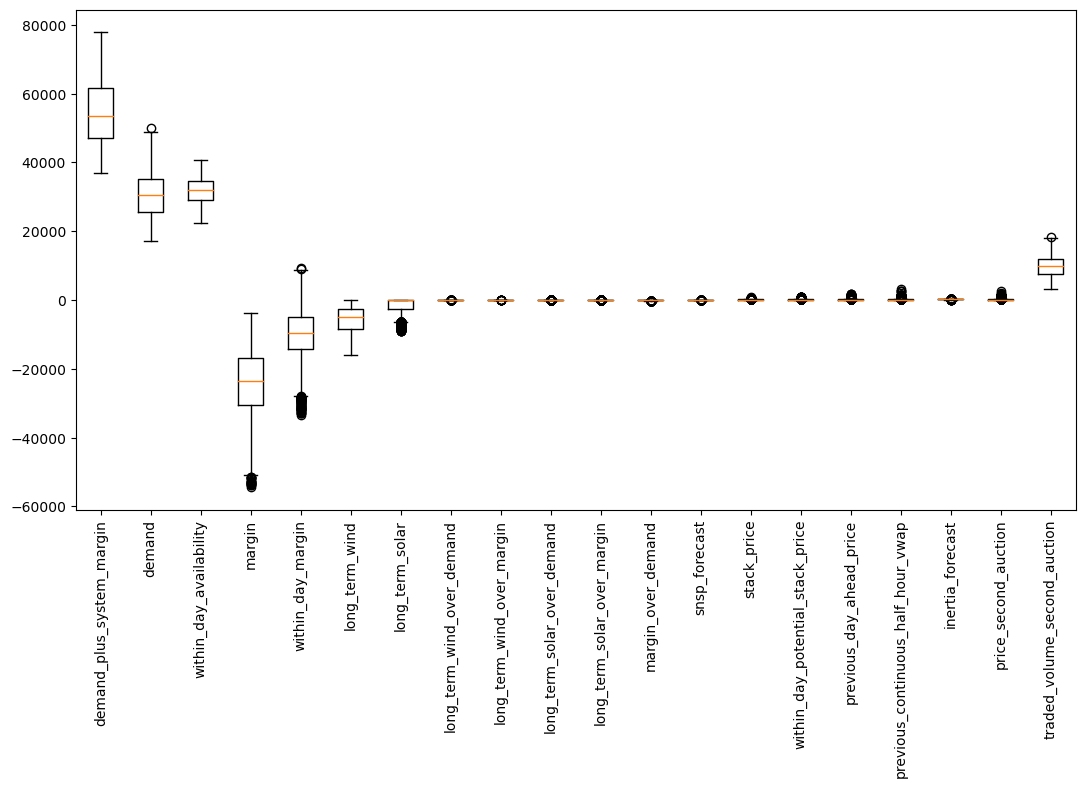

In [22]:
def draw_boxplot(df,cols):
    fig = plt.figure(figsize =(10, 5))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    # Creating plot
    bp = ax.boxplot(df[cols]);
    # x-axis labels
    ax.set_xticklabels(cols, rotation=90);
    
draw_boxplot(for_df,for_df.columns[1:])

## Linear regression
We will run a linear regression analysis on the forecast dataset. Linear regression assumes a relationship between the dependent and the independent variables. But we know from the heatmap that our data has multicollinearity so we should first make a variable selection so that we can reduce it.
#### Checking for multicollinearity
Since we have 21 columns it will make sense to reduce the regular correlation heatmap into a heatmap with only relavant information about highly correlated columns with correlation lesser than-0.5 or greater than 0.5.

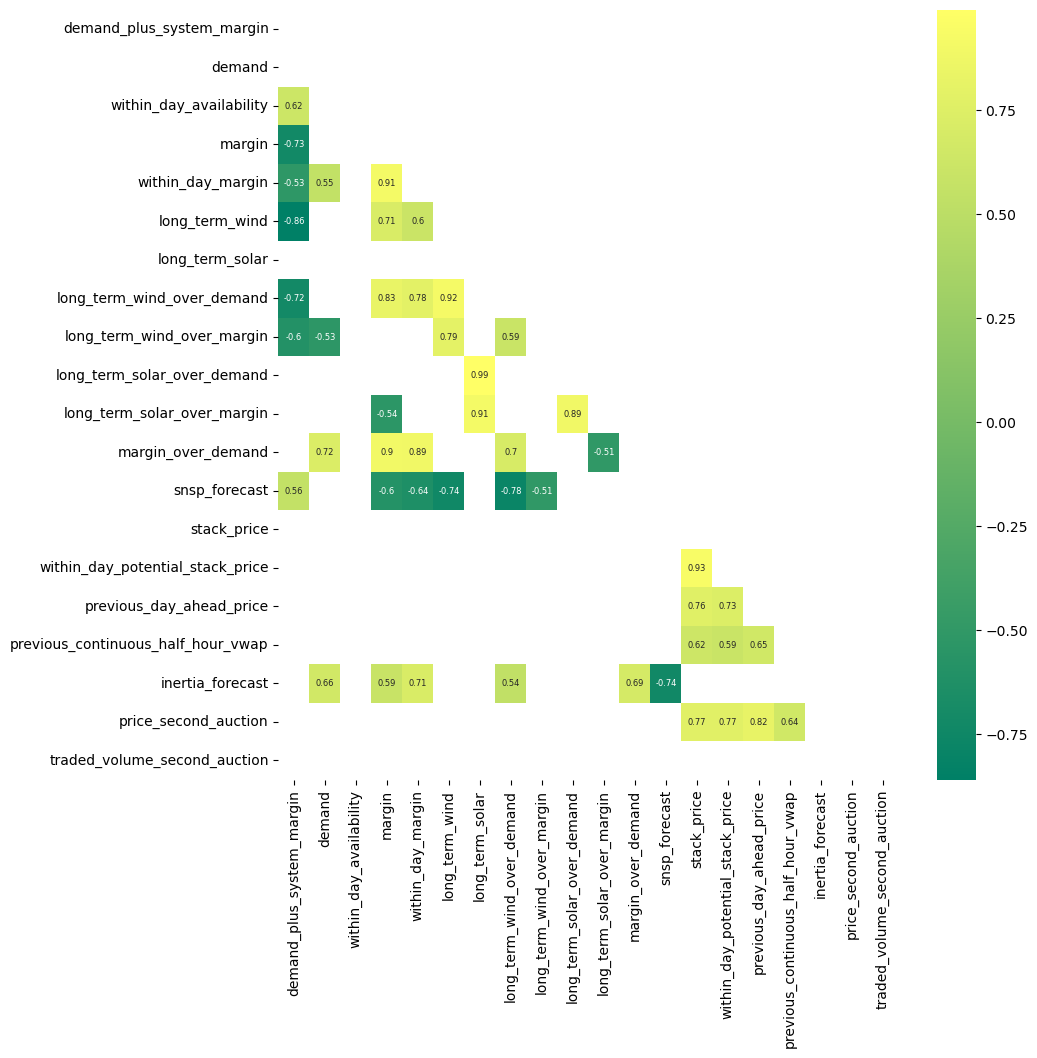

In [23]:
plt.figure(figsize=(10,10))
df_corr=for_df[for_df.columns[1:]].copy()
cor_df=df_corr.corr()
sns.heatmap(cor_df[(cor_df >= 0.5) | (cor_df <= -0.5)],annot=True,cmap='summer',mask = np.triu(cor_df),
            annot_kws={"fontsize":6});

#### Variance Inflation Factor(VIF)
Above heatmap suggests that there is multicollinearity in our data we will look at Variance Inflation Factor also to also consider multivariate relationships rather only bivariate relations. <br>
If the VIF value is higher than 10, it is usually considered to have a high correlation with other independent variables. It can also be visualized by a sorted dataframe as shown below:

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = for_df.columns[1:]
vif["vif_Factor"] = [variance_inflation_factor(np.array(for_df[for_df.columns[1:]].values, dtype=float), i) 
                     for i in range(for_df.shape[1]-1)]
vif[vif.vif_Factor>10].sort_values(by='vif_Factor',ascending=False)

,features,vif_Factor
0,demand_plus_system_margin,1.329747e+08
1,demand,4.238075e+07
3,margin,2.881784e+07
2,within_day_availability,5.196508e+03
4,within_day_margin,7.658918e+02
5,long_term_wind,6.635971e+02
17,inertia_forecast,2.592698e+02
11,margin_over_demand,2.518229e+02
7,long_term_wind_over_demand,1.948585e+02
6,long_term_solar,1.822924e+02


Based on the correlation heatmap and Variance Inflation Factor analysis above:
* We can drop `demand_plus_system_margin` as it is derived from `demand` and `margin` and is correlated with `within_day_availability`.
* `long_term_wind_over_demand`, `long_term_solar_over_demand`, `margin_over_demand`, `long_term_wind_over_margin`, `long_term_solar_over_margin` should also be dropped as they are derived variables. It will also help us to reduce the sparsity of the dataset.
* `within_day_margin`, `within_day_potential_stack_price` is dependant on `margin` and `stack_price` respectively so they can be dropped too. 
*  We can drop `traded_volume_second_auction` as it will not be available at the actual time when we will do the forecast so we will not consider it here.

Hence, in our feature columns we will exclude these columns.
##### Train-test split
As it is a sequential data, we are splitting the dataset based on a date (Feb end 2022).

In [25]:
from sklearn.model_selection import train_test_split
feature_col_names = ['demand','within_day_availability', 'margin','long_term_wind', 
                     'long_term_solar', 'snsp_forecast','previous_day_ahead_price', 
                     'previous_continuous_half_hour_vwap','inertia_forecast','stack_price']


predict_col_name = ['price_second_auction']

for_df = for_df.set_index('Date (WET)') 
train = for_df.loc[:'2022-02-28']
test = for_df.loc['2022-03-01':]

X_train= train[feature_col_names]
X_test= test[feature_col_names]
y_train= train[predict_col_name]
y_test= test[predict_col_name]

print(f"{round(len(train)*100/len(for_df),2)}:{round(len(test)*100/len(for_df),2)}")

68.4:31.6


It's an almost 70:30 split. Which is an ideal proportion. Now, we can go ahead and implement linear regression for forecasting.

In [26]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

We will use performance matrix to understand the performance of the model. We will use R square and root mean square error (RMSE) for this. The purpose of using metrics is to evaluate which model works best on the dataset.

As we know that adjusted R-squared compensates for the addition of variables and only increases if the new term enhances the models. So we will also consider adjusted R-square to compare the models.

R square on training data: 0.63
R square on testing data: 0.82
Adj. R square on training data: 63.06 %
Adj. R square on testing data: 82.44 %
RMSE on train data: 62.05
RMSE on test data: 46.14




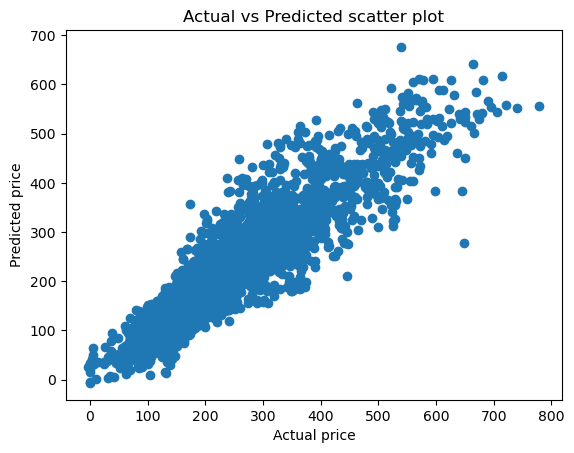

In [27]:
Rsq_train = linreg.score(X_train, y_train)
print("R square on training data: {}".format(round(Rsq_train,2)))
Rsq = linreg.score(X_test, y_test)
print("R square on testing data: {}".format(round(Rsq,2)))
adj_r2 = (1 - (1 - Rsq_train) * ((X_train.shape[0] - 1) / 
          (X_train.shape[0] - X_train.shape[1] - 1)))
print("Adj. R square on training data: {} %".format(round(adj_r2*100,2)))
adj_r2 = (1 - (1 - Rsq) * ((X_test.shape[0] - 1) / 
          (X_test.shape[0] - X_test.shape[1] - 1)))
print("Adj. R square on testing data: {} %".format(round(adj_r2*100,2)))
y_train_pred = linreg.predict(X_train)
y_pred = linreg.predict(X_test)
print("RMSE on train data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_train,y_train_pred)),2)))
print("RMSE on test data: {}".format(round(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),2)))

print('\n')
plt.scatter(x=y_test['price_second_auction'],y=y_pred);
plt.title('Actual vs Predicted scatter plot');
plt.xlabel("Actual price")
plt.ylabel("Predicted price");

The model really generalised on the data set with the R square metric of 82 percent on test data and it is notable that testing R square is way greater than training R square 63%. Meaning 82 percent of the variations in the test data is explained by the predictors with out overfitting on the train data.

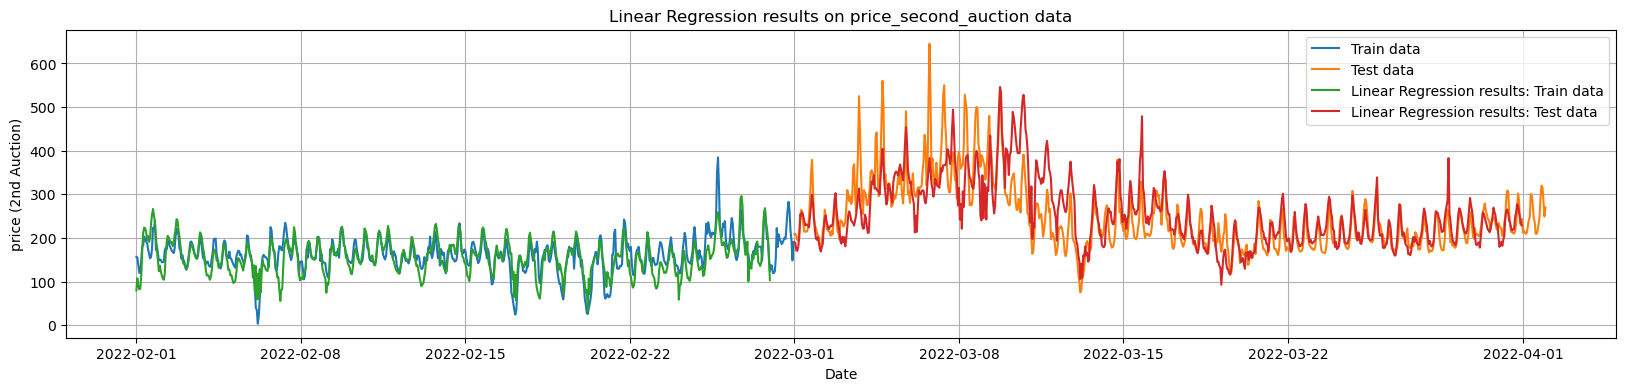

In [28]:
def plot_result(col,title,y_test_pred,y_train_pred): 
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(train[col].loc['2022-02-01':'2022-02-28'], label='Train data')
    plt.plot(test[col].loc['2022-03-01':'2022-04-01'], label='Test data')
    if len(y_train_pred)!=0:
        plt.plot(train.index[9506:10154], y_train_pred[9506:10154], label=title+": Train data")
    plt.plot(test.index[:743], y_test_pred[:743], label=title+": Test data")
    plt.legend(loc='best')
    plt.title(f"{title} on {col} data")
    plt.xlabel("Date")
    plt.ylabel("price (2nd Auction)");
plot_result('price_second_auction','Linear Regression results',y_pred,linreg.predict(X_train))

As it was hard to compare the whole plot for visual inspection with almost 15000 data points so we need to take a look at a subset of this dataset. In the plot above, we are looking at 650 data point closer to the test and train split point (Feb end 2022).
#### Symmetric Mean Absolute Percentage Error (SMAPE)

In [29]:
def smape(Actual, Forcasted):
    return 100/len(Actual) * np.sum(2 * np.abs(Forcasted - Actual) / (np.abs(Actual) + np.abs(Forcasted)))

round(smape(test['price_second_auction'].values,  y_pred.ravel()),2)

17.1

Smape score with Linear regression for this forecast is already nice. 10-20% is considered a good forecast though for a highly accurate forecast Smape score should be lower than 10%.<br>
But for our purpose we can use Linear regression as our final model. Using this model, we can have the `price_forecast_second_auction`. Let's first ensure that the rows for both auction and forecasting data is same.

In [30]:
auc_df = auc_df.set_index('Date (WET)') 
auc_df = auc_df[~auc_df.index.duplicated()]
for_df = for_df[~for_df.index.duplicated()]
print(f"rows in forecasting data: {for_df.shape[0]}")
print(f"rows in auction data: {auc_df.shape[0]}")

rows in forecasting data: 14878
rows in auction data: 14878


#### Forecasting the second auction price

In [31]:
auc_df['price_forecast_second_auction'] = linreg.predict(for_df[feature_col_names])
auc_df.head()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction
Date (WET),,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.956097
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.893960
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.561914
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.683111
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.643551


# 3. Determining the optimal non-physical trading strategy: 
> **Context**: The day-ahead market seeks to arrange most of the short-term supply and demand the day prior to delivery times due to technical considerations and risk mitigation. Day-ahead markets usually consist of sealed-bid pay-as-cleared auctions where market participants submit price-volume bids to buy or sell electricity for the 24 hours of the next operating day. Meaning that every auction participant submits a bid of how much energy to buy or sell at a certain price without knowing the other bids. Within pay-as-cleared a uniform price for both buyers and sellers is determined by the market clearing price based on the so-called merit-order-model. All sell orders below this clearing price and all buy orders above this clearing price will be accepted and priced at the clearance price. <br>
> Based on the above context, we need to develop a little trading algorithm that maximizes profits from financial trades between two day- ahead auctions in Great Britain. The two auctions:
> * function as mentioned with sealed bids and based on the pay-as-cleared mechanism.
> * market hourly bundles of electricity, so auction participants submit bids to buy or sell electricity for every
> hour of the next operating day.
> * are sequential, meaning that you first must submit your bids for the first auction, wait for its results and
> afterwards submit your bids for the second auction (a bid consists of a volume you want to buy or sell and
> the price you want to pay or receive).

Now we need to determine the optimal trading strategy. The trading strategy should be designed to maximize profits from the non-physical financial trades between the two auctions. We can use various optimization techniques such as linear programming or dynamic programming to determine the optimal trading strategy. Let's break down our optimization problem first:

If $V_{s}$ and $V_{b}$ are volumes of electricty sold and bought for an hour respectively. Whereas $P_{s}$ and $P_{b}$ are selling price and purchasing prices in GBP/MWh respectively, and $F_{t}$ = 5 GBP/MWh is the fee per trade (We are assuming that every trade results in 5 GBP/MWh of costs for taxes and fees which we must account for in
our strategy.), then:
* **Objective function**: 
1. Profit maximization for a whole day from financial trades (including system prices) in 2 day-ahead auctions: <br><br>$$maxZ = \sum (V_{s}P_{s})-\sum (V_{b}P_{b}) - V_{t}F_{t} + \Delta P_{sys}$$ $$V_{t} = \sum (V_{s} + V_{b})$$ Where $V_{t}$ is total volume traded in a day and $\Delta P_{sys}$ is the post auction system price settlement in a day, which can be both positive and negative depending on the energy imbalance ($\Delta$) when $\sum V_{s} \neq \sum V_{b}$. <br><br>
2. Risk minimization from energy imbalance. This objective is not required to be met if we aim for $\Delta = 0$. Otherwise we need to minimize it: $$maxZ=\begin{equation}
\left\{ 
  \begin{aligned}
    & -\sum (V_{b}P_{b}) - V_{b}F_{t} + \Delta P_{sys} &if \,&  V_{s}=0\\
    & \sum (V_{s}P_{s}) - V_{s}F_{t} + \Delta P_{sys} &if \,&  V_{b}=0\\
    & \sum (V_{s}P_{s})-\sum (V_{b}P_{b}) - V_{t}F_{t} + \Delta P_{sys} & else\\
  \end{aligned}
  \right.
\end{equation}
$$
<br><br>
* **Constraints**: 
1. **Net position**: As we act as a non-physical trader, our net position resulting from the trades on the two auctions should be zero for all timesteps, as we cannot provide this net position to the grid on the next day. The difference between our net market position after both auctions and the energy you can provide will be settled with the so-called system prices. <br>Ideally, net position resulting from the trades on the two auctions should be zero for all timesteps or otherwise we need to pay for the energy imbalance with system price. <br>We are also considering Minimum price and volume increments: Pricetick: 0.1 GBP/MWh and Volumetick: 0.1 MW<br><br>$$ V_{s}- V_{b} = 0 $$ $$ V_{s},V_{b} \ge 0.1 MW$$ $$B_{t} \ge P_{s}, P_{b} \ge 0.1 GBP/MWh $$  Where $B_{t}$ is the maximum allocated budget per trade. <br><br>2. **Bid acceptance** We must account for the cases where we did not get accepted if our sell bid is above or the buy bid is below the clearing price. Bid acceptance through pay-as-cleared price ($P_{c}$):<br><br> $$P_{s}=\begin{equation}
\left\{ 
  \begin{aligned}
    & P_{c} &if \,&  P_{s} < P_{c}\\
    & 0 & else\\
  \end{aligned}
  \right.
\end{equation}
$$
$$P_{b}=\begin{equation}
\left\{ 
  \begin{aligned}
    & P_{c} &if \,&  P_{b} > P_{c}\\
    & 0 & else\\
  \end{aligned}
  \right.
\end{equation}
$$
Other constraints include: sealed bids, sequential bidding.
<br><br>
* **Controllable Decision variables**: $V_{s}$, $V_{b}$, $P_{s}$ and $P_{b}$ bids to buy/sell electricity for every hour of the next operating day. (a bid consists of a volume you want to buy or sell and the price you want to pay or receive)
<br><br>
* **Inputs**: Price forecasts for both auctions and forecasted price range of the system prices.

Note: Negative values for energy translates to buying and vice versa positive values translates to selling of energy to the market.

**System prices**: 
* When partcipant has generated less power or used more power then they need to buy that amount of power at system price.
* When partcipant has generated more power or used less power then they need to sell that amount of power at system price.
* Long System: When System prices are negative; supply is overwhelming but demand is low. Consumers are paid to consume power. As traders we should provide less energy than planned to profit from it.
* Short System: When System prices are positive; supply is low and demand is high. As traders we should provide more energy than planned to profit from it.

So, it’s also possible to earn money with system prices from either providing less energy than planned to
the system (if system prices are negative) or from taking demand out of the market (if system prices are
positive).
* Though at the time of the auctions, we do not know exactly what the system price will be, we only have a forecast of its price range available.

## 3.1. Base-level naive strategy to benchmark other startegies
**Strategy**: Contracting based on the forecasted price change for each period with zero energy imbalance in the day-ahead market. 
* If forecasted price went higher than the trading cost (i.e. forecasted_price_diff >10GBP) in 2nd auction then buy 10MW in 1st auction and sell 10MW in the 2nd auction.
* If forecasted price went lower than the trading cost (i.e. forecasted_price_diff <-10GBP) in 2nd auction then sell 10MW in 1st auction and buy 10MW in the 2nd auction.

$$Profit: Z = (10*P_{s})- (10*P_{b}) - 20*5 + 0$$

**Evaluation**: we can use various metrics such as profit margin, return on investment, and accuracy to evaluate the performance of the algorithm and optimize it further.

For the implementation, we will need to get the difference between forecasted prices. We will also need to merge auction and system price data.


In [32]:
sys_df['forecast_system_avg'] = sys_df[["forecast_system_price_low","forecast_system_price_high"]].mean(axis=1)
sys_df = sys_df[~sys_df.index.duplicated()]
sys_df = sys_df.set_index('Date (WET)')
auc_df = pd.merge(auc_df, sys_df, left_index=True, right_index=True)
auc_df["forecasted_price_diff"] = auc_df['price_forecast_second_auction'] - auc_df['price_forecast_first_auction']
auc_df.head()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,forecast_system_avg,forecasted_price_diff
Date (WET),,,,,,,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.956097,48.33,44.89,73.15,46.610,10.766097
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.893960,54.35,53.26,71.95,53.805,7.473960
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.561914,32.66,65.86,54.56,49.260,2.431914
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.683111,41.55,63.43,70.73,52.490,-0.596889
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.643551,26.62,66.91,54.98,46.765,-0.546449


For calculation of planned profit, we are taking the auction price as the clearing price. We are calculating profit only in the cases when the bid prices will be accepted.

In [33]:
def profit_naive(row):
    #naive strategy (bidding price=forecasted price) as per the acceptance or rejection of bid price
        if row['forecasted_price_diff']>10 and row['price_first_auction'] < row['price_forecast_first_auction']\
        and row['price_second_auction'] > row['price_forecast_second_auction']:
            
            row['Plan_Profit_naive'] = row['forecasted_price_diff']*10 - 100
            row['Act_Profit_naive'] = (row['price_second_auction']-row['price_first_auction'])*10-100
            
        elif row['forecasted_price_diff']<-10 and row['price_first_auction']>row['price_forecast_first_auction']\
        and row['price_second_auction'] < row['price_forecast_second_auction']:
            
            row['Plan_Profit_naive'] = row['forecasted_price_diff']*-10 - 100
            row['Act_Profit_naive'] = (row['price_first_auction']-row['price_second_auction'])*10-100
            
        else:
            
            row['Plan_Profit_naive'] = 0 
            row['Act_Profit_naive'] = 0
        return row
    
auc_df = auc_df.apply(profit_naive,axis=1)            
auc_df.head()            

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,price_forecast_first_auction,price_forecast_second_auction,forecast_system_price_low,forecast_system_price_high,system_price,forecast_system_avg,forecasted_price_diff,Plan_Profit_naive,Act_Profit_naive
Date (WET),,,,,,,,,,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,54.19,64.956097,48.33,44.89,73.15,46.610,10.766097,0.0,0.0
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,53.42,60.893960,54.35,53.26,71.95,53.805,7.473960,0.0,0.0
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,50.13,52.561914,32.66,65.86,54.56,49.260,2.431914,0.0,0.0
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,50.28,49.683111,41.55,63.43,70.73,52.490,-0.596889,0.0,0.0
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,47.19,46.643551,26.62,66.91,54.98,46.765,-0.546449,0.0,0.0


#### Actual and planned profits per trade comparision  for whole period

In [34]:
print(f"Planned profit: {round(auc_df['Plan_Profit_naive'].sum()/len(auc_df[auc_df['Plan_Profit_naive']!=0]),2)}")
print(f"Actual profit: {round(auc_df['Act_Profit_naive'].sum()/len(auc_df[auc_df['Act_Profit_naive']!=0]),2)}")
tot_invested = auc_df[auc_df['Act_Profit_naive']!=0].price_first_auction.sum() + \
auc_df[auc_df['Act_Profit_naive']!=0].price_second_auction.sum()+ 2*len(auc_df[auc_df['Act_Profit_naive']!=0])*5
ROI = round(auc_df['Act_Profit_naive'].sum()*100/tot_invested,2)
print(f"ROI: {ROI}")

Planned profit: 82.74
Actual profit: 343.19
ROI: 74.89


Naive starategy is not that bad it is giving us better profits per trade than planned. It is a good base startegy.

## 3.2. Manual Strategy including Energy Imbalance 
**Strategy**: Contracting based on the forecasted price change in only one of the two auctions for each period with non-zero energy imbalance in the day-ahead market. 
* If system price is negative and price_forecast_second_auction went higher than the overall trading cost (i.e. price_forecast_second_auction > 5GBP - forecast_system_avg) in 2nd auction then sell 10MW in the 2nd auction but don't deliver and let the imbalance get settled otherwise sell 10 MW but don't deliver in the 1st auction.
*  If system price is positive and price_forecast_second_auction went lower than the overall trading cost (i.e.  price_forecast_second_auction < forecast_system_avg - 5GBP) in 2nd auction then buy 10MW in the 2nd auction but don't consume and let the imbalance get settled otherwise buy 10 MW but don't consume in the 1st auction.

$$MaxZ=\begin{equation}
\left\{ 
  \begin{aligned}
    & -(10*P_{b}) - 10*5 + 10*P_{sys} &if \,&  P_{sys}>0\\
    & (10*P_{s}) - 10*5 +  10*P_{sys} &if \,&  P_{sys}<0\\
  \end{aligned}
  \right.
\end{equation}$$

In [35]:
def profit_manual(row):
    #manual strategy (bidding price=forecasted price) with energy imbalance 
    #as per the acceptance or rejection of bid price
        if row['forecast_system_avg']<0:
            if row['price_forecast_second_auction'] > (5 - row['forecast_system_avg']) and\
            row['price_second_auction'] > row['price_forecast_second_auction']:
                
                row['Plan_Profit_man'] = row['price_forecast_second_auction']*10-50+row['forecast_system_avg']*10
                row['Act_Profit_man'] = row['price_second_auction']*10-50+row['system_price']*10
                
            elif row['price_forecast_first_auction'] > (5 - row['forecast_system_avg']) and\
            row['price_first_auction'] > row['price_forecast_first_auction']:
                
                row['Plan_Profit_man'] = row['price_forecast_first_auction']*10-50+row['forecast_system_avg']*10
                row['Act_Profit_man'] = row['price_first_auction']*10-50+row['system_price']*10
                
        elif row['forecast_system_avg']>0:
            if row['price_forecast_second_auction'] < (row['forecast_system_avg'] -  5) and\
            row['price_second_auction'] < row['price_forecast_second_auction']:
                
                row['Plan_Profit_man'] = -row['price_forecast_second_auction']*10-50+row['forecast_system_avg']*10
                row['Act_Profit_man'] = -row['price_second_auction']*10-50+row['system_price']*10
                
            elif row['price_forecast_first_auction'] < (row['forecast_system_avg'] - 5) and\
            row['price_second_auction'] < row['price_forecast_second_auction']:
                row['Plan_Profit_man'] = -row['price_forecast_first_auction']*10-50+row['forecast_system_avg']*10
                row['Act_Profit_man'] = -row['price_first_auction']*10-50+row['system_price']*10
        else:
            row['Plan_Profit_naive'] = 0 
            row['Act_Profit_naive'] = 0
        return row
    
auc_df = auc_df.apply(profit_manual,axis=1)            
auc_df.head()  

,Act_Profit_man,Act_Profit_naive,Plan_Profit_man,Plan_Profit_naive,forecast_system_avg,forecast_system_price_high,forecast_system_price_low,forecasted_price_diff,price_first_auction,price_forecast_first_auction,price_forecast_second_auction,price_second_auction,system_price,traded_volume_first_auction,traded_volume_second_auction
Date (WET),,,,,,,,,,,,,,,
2021-01-01 00:00:00,NaN,0.0,NaN,0.0,46.610,44.89,48.33,10.766097,68.0,54.19,64.956097,65.73,73.15,2923.7,5102.4
2021-01-01 01:00:00,NaN,0.0,NaN,0.0,53.805,53.26,54.35,7.473960,62.7,53.42,60.893960,64.96,71.95,2825.0,4771.5
2021-01-01 02:00:00,NaN,0.0,NaN,0.0,49.260,65.86,32.66,2.431914,56.0,50.13,52.561914,60.47,54.56,2611.4,4176.2
2021-01-01 03:00:00,NaN,0.0,NaN,0.0,52.490,63.43,41.55,-0.596889,50.1,50.28,49.683111,52.50,70.73,2669.3,3755.9
2021-01-01 04:00:00,NaN,0.0,NaN,0.0,46.765,66.91,26.62,-0.546449,50.0,47.19,46.643551,48.98,54.98,2741.4,4047.5


#### Actual and planned profits per trade comparision  for whole period

In [36]:
print(f"Planned profit: {round(auc_df['Plan_Profit_man'].sum()/len(auc_df[auc_df['Plan_Profit_man']!=np.nan]),2)}")
print(f"Actual profit: {round(auc_df['Act_Profit_man'].sum()/len(auc_df[auc_df['Act_Profit_man']!=np.nan]),2)}")
tot_invested = (auc_df[auc_df['Act_Profit_man']!=np.nan].price_first_auction.sum() + \
                auc_df[auc_df['Act_Profit_man']!=np.nan].price_second_auction.sum())/2 + \
                len(auc_df[auc_df['Act_Profit_man']!=np.nan])*5+\
                auc_df[auc_df['Act_Profit_man']!=np.nan].system_price.sum()
ROI = round(auc_df['Act_Profit_man'].sum()*100/tot_invested,2)
print(f"ROI: {ROI}")

Planned profit: 77.8
Actual profit: 46.62
ROI: 14.82


According to results it's not a better strategy than our naive base startegy.
## 3.3. Optimised Strategy on a whole day (including Energy Imbalance)
In all above strategies we have taken the decision based on price only. We should also use volumes with optimization techniques.<br> Let's keep upper limit for volumes to be 10 MW so that we can compare the optimised starategy with our base strategies.<br>
*Note* : 
* We are optimising the prices for a random date '2022-01-31', it can be repeated for any date.
* We have assumed that in 1st auction we will sell and in 2nd auction we will buy energy. 
* For selling price to be accepted we are keeping it's upper bound below the mean of forecasted price of 1st auction.

For our non-linear optimization problem with multiple variables, we will be using the **scipy.optimize** module which provides several optimization algorithms for non-linear optimization problems, including the minimize function which can minimize a given objective function with multiple variables subject to constraints.

In [37]:
import numpy as np
from scipy.optimize import minimize

# decision variables: Vs, Vb, Ps, Pb for every hour of the next operating day

def Vt(Vs, Vb):
    #the total volume traded in a day (Vt)
    return np.sum(Vs) + np.sum(Vb)

# objective function: maximize profit from financial trades
def objective(x):
    Vs = x[:24]
    Vb = x[24:48]
    Ps = x[48:72]
    Pb = x[72:]
    Vt_val = Vt(Vs, Vb)
    max_profit = np.sum(Vs*Ps) - np.sum(Vb*Pb) - Vt_val*5 - (np.sum(Vs*Psys) - np.sum(Vb*Psys))
    return -max_profit # minimize negative profit

def volume_constraint(x):
    Vs = x[:24]
    Vb = x[24:48]
    return Vs - Vb

def budget_constraint(x, Bt=np.full((48,), 10)):
    Vs = x[:24]
    Vb = x[24:48]
    return Bt - np.concatenate((Vs, Vb)) # maximum allocated budget per trade
                                   
def selling_price_constraint(x):
    Ps = x[48:72]
    return Pc1 + Ps

def buying_price_constraint(x):
    Pb = x[72:]
    return Pb - Pc2 

dates = list(set([str(i.date()) for i in auc_df.index]))
input_date = '2022-01-31'
Pc1 = auc_df['price_forecast_first_auction'][input_date:input_date].values
Pc2 = auc_df['price_forecast_second_auction'][input_date:input_date].values
Pca1 = auc_df['price_first_auction'][input_date:input_date].values
Pca2 = auc_df['price_second_auction'][input_date:input_date].values
Psys = auc_df['forecast_system_avg'][input_date:input_date].values
Psys_a = auc_df['system_price'][input_date:input_date].values

# decision variables bounds
bounds = [(0.1, 10)]*24 + [(0.1, 10)]*24 + [(0.1, round(Pc1.mean()))]*24 + [(0.1, 100)]*24

# set up input parameters
Bt = np.full((48,), 10) # maximum allocated volume budget per trade

# solve optimization problem for every hour
optimal_bids = []
for i in range(24):
    initial_guess = [0.1]*24 + [0.1]*24 + [50]*24 + [50]*24 # initial guess
    constraints = [{'type': 'eq', 'fun': volume_constraint},
                   {'type': 'ineq', 'fun': budget_constraint, 'args': (Bt[i],)},
                   {'type': 'ineq', 'fun': selling_price_constraint},
                  {'type': 'ineq', 'fun': buying_price_constraint}]
    res = minimize(objective, initial_guess, constraints=constraints, options={'eps': 1e-3, 'ftol': 1e-9},
                   bounds=bounds)
    optimal_bids.append(res.x)
    
bid_dict={}
for bid in optimal_bids:
    Ps = np.where(bid[48:72] < Pca1, bid[48:72], 0)
    Pb = np.where(bid[72:] > Pca2, bid[72:], 0)
    Vs = np.where(Ps>0, bid[:24], 0) 
    Vb = np.where(Pb>0, bid[24:48], 0) 
    bid_dict['Vs']=Vs
    bid_dict['Vb']=Vb
    bid_dict['Ps']=Ps
    bid_dict['Pb']=Pb
    bid_dict['Pca1']=Pca1
    bid_dict['Pca2']=Pca2
    bid_dict['Psys_a']= Psys_a
    bid_dict['Plan_Profit']= Vs*Ps-Vb*Pb-5*(Vs+Vb)- (Vs*Psys - Vb*Psys)
    bid_dict['Actual_Profit'] =(Vs*Pca1-Vb*Pca2-5*(Vs+Vb)- (Vs*Psys_a - Vb*Psys_a))
bid_df = pd.DataFrame(bid_dict,columns=['Vs','Vb','Ps','Pb','Pca1','Pca2','Psys_a','Plan_Profit','Actual_Profit'])
bid_df.style.format("{:.2f}")

,Vs,Vb,Ps,Pb,Pca1,Pca2,Psys_a,Plan_Profit,Actual_Profit
0,0.00,0.00,0.00,0.00,133.30,109.60,111.74,0.00,0.00
1,0.00,0.00,0.00,0.00,111.60,103.43,166.00,0.00,0.00
2,0.00,10.00,0.00,100.00,91.50,90.10,-23.66,104.15,-1187.60
3,0.00,0.00,0.00,0.00,77.60,79.75,-44.68,0.00,0.00
4,0.00,0.00,0.00,0.00,82.00,79.10,232.00,0.00,0.00
5,0.00,0.00,0.00,0.00,138.20,140.59,230.00,0.00,0.00
6,0.00,0.00,0.00,0.00,180.00,188.01,230.00,0.00,0.00
7,10.00,0.00,193.00,0.00,197.00,187.18,193.82,237.05,-18.20
8,10.00,0.00,193.00,0.00,213.30,206.20,189.09,-3344.95,192.10
9,10.00,0.00,193.00,0.00,225.90,217.73,125.00,1326.55,959.00


#### Actual and planned profits per trade comparision  for a day

In [38]:
print(f"Planned profit: {round(bid_df['Plan_Profit'].sum()/len(bid_df[bid_df['Plan_Profit']!=0]),2)}")
print(f"Actual profit: {round(bid_df['Actual_Profit'].sum()/len(bid_df[bid_df['Actual_Profit']!=0]),2)}")
tot_invested = (bid_df[bid_df['Actual_Profit']!=0].Pca1.sum() + bid_df[bid_df['Actual_Profit']!=0].Pca2.sum())/2+\
                len(bid_df[bid_df['Actual_Profit']!=0])*5 + \
                bid_df[bid_df['Actual_Profit']!=0].Psys_a.sum()
ROI = round(bid_df['Actual_Profit'].sum()*100/tot_invested,2)
print(f"ROI: {ROI}")

Planned profit: 15.77
Actual profit: 39.58
ROI: 10.11


So far, 3rd approach has the highest ROI. Although, it will vary on day to day basis and we have not computed it on the overall data as we did it for our manual strategies but we know it is optimized and will perform better. <br> Below we can see that the other manual strategies don't give us as much profit per trade on the same day ('2022-01-31') as this strategy does.

In [39]:
print(f"Actual profit with manual strategy on 2022-01-31: {round(auc_df['Act_Profit_man'][input_date:input_date].sum()/len(auc_df[auc_df['Act_Profit_man'] !=np.nan][input_date:input_date]),2)}")
print(f"Actual profit with naive strategy on 2022-01-31: {round(auc_df['Act_Profit_naive'][input_date:input_date].sum()/len(auc_df[auc_df['Act_Profit_naive'] !=np.nan][input_date:input_date]),2)}")

Actual profit with manual strategy on 2022-01-31: 28.52
Actual profit with naive strategy on 2022-01-31: 0.0


# 4. Implementing the final trading algorithm. 
We can now finalize the trading algorithm as a whole which should take as input the actual prices and traded volumes data of both auctions as well as the price forecast for the first auction and the input variables that can be used to forecast the prices of the second auction. It should output the optimal trades to be made between the two auctions to maximize profits. <br>
We have found out that for forecasting for best results so far, we should use **Linear regression** model to predict prices of the second auction and for profit optimization we should use 3rd approach of **Optimised Strategy on a whole day** with Scipy.
### Future work:
* For price forecasting, we could try using other high performing time series methods such as GBM, lstm/rnn models with sliding windows. Time series frameworks like darts and FBprophet can also be utilized.
* Pyomo and gekko are optimization frameworks which can be used and Reinforecemnt Learning is also a worth try for trading optimization but it will take much time and effort because making the simulation environment is a rigorous task.

### References:
* https://www.iaee.org/en/publications/init2.aspx?id=0
* https://www.researchgate.net/publication/261433593_European_market_integration_with_both_physical_and_non-physical_markets
* https://www.mdpi.com/1996-1073/11/6/1345
* https://www.researchgate.net/publication/272905224_Optimization_in_day-ahead_planning_of_energy_trading
* https://drops.dagstuhl.de/opus/volltexte/2012/3550/pdf/11.pdf
* https://reader.elsevier.com/reader/sd/pii/S2352467722001175?token=46E62C1BF9382C1FD2BBB0F1BAE373FC0B367880D1C829A8082912E314A5FDDC8FFCC8509E2E94E53F27EC5139EAA2C8&originRegion=eu-west-1&originCreation=20230312115039
* https://link.springer.com/article/10.1007/s00291-021-00646-9